In [ ]:
# Author : Trong Canh Nguyen

# This script considers all the products a user has ordered
#
# We train a model computing the probability of reorder on the "train" data
#
# For the submission, we keep the orders that have a probability of
# reorder higher than a threshold


import numpy as np
import pandas as pd
import lightgbm as lgb
import h5py
import gc
IDIR = '../input/'
FEATURES_PATH = './features3/'

IDIR4 = '../input/'
FEATURES_PATH4 = './features3_2/'

In [ ]:
gc.collect()

## Data Load

In [ ]:
import pickle
with open(FEATURES_PATH + 'dtypes.pickle', 'rb') as f:
    dtype_dict = pickle.load(f)
dtype_dict

### Combine data

In [ ]:
data0 = pd.read_hdf(FEATURES_PATH + "data.h5", "data")
data0.reset_index(inplace=True)
print("memory = ", data0.memory_usage().sum()/1000000)

In [ ]:
data0['data_set'] = 0
data0['data_set'] = data0['data_set'].astype(np.int8)

In [ ]:
data4 = pd.read_hdf(FEATURES_PATH4 + "data4.h5", "data")
data4.reset_index(inplace=True)
print("memory = ", data4.memory_usage().sum()/1000000)

In [ ]:
data4['data_set'] = 1
data4['data_set'] = data4['data_set'].astype(np.int8)

In [ ]:
data = pd.concat([data0, data4])

In [ ]:
data.set_index(['user_id', 'product_id', 'data_set'], inplace = True)

In [ ]:
store = pd.HDFStore(FEATURES_PATH + "./data_total.h5")
store["data"] = data
store.close()

### Load from h5

In [ ]:
data = pd.read_hdf(FEATURES_PATH + "data_total.h5", "data")

In [ ]:
print("len data", len(data))
print("memory = ", data.memory_usage().sum()/1000000)

### Data train

In [ ]:
data_train = data[data.user_eval_set == "train"]

In [ ]:
# save
data_train.to_hdf(FEATURES_PATH + "./data_train_total.h5", "data", mode ="w")

In [ ]:
# Load
data_train = pd.read_hdf(FEATURES_PATH + "data_train_total.h5", "data")

In [ ]:
print("len data train", len(data_train))
print("memory = ", data_train.memory_usage().sum()/1000000)

### Data test

In [ ]:
data_test = data[data.user_eval_set == "test"]
data_test.to_hdf(FEATURES_PATH + "./data_test_total.h5", "data", mode = "w")

In [13]:
data_test = pd.read_hdf(FEATURES_PATH + "data_test_total.h5", "data")

In [ ]:
print("len test train", len(data_test))
print("memory = ", data_test.memory_usage().sum()/1000000)

# MODEL

In [ ]:
columns = [   
    'aisle_id', 
 'department_id',
    'user_eval_set',
    'up_reordered',
 'product_reorder_ratio', 
 'up_add_to_cart_order_mean',
 'up_days_since_last_order',  
 'up_in_same_day_previous_order',  
 'up_order_rate',
 'up_order_rate_since_first_order', 
 'up_orders',
 'up_orders_since_last_order',  
 'aisle_reorder_rate', 
 'dep_reorder_rate',             
 'user_aisle_reorder_rate',
 'user_days_since_last_order', 
 'user_dep_reorder_rate', 
 
 'user_order_size_mean', 
 'user_reorder_rate', 
 'user_total_order'
  ]

data = data[columns]

In [5]:
features = [    
    'product_reorder_ratio', 
 'up_add_to_cart_order_mean',
 'up_days_since_last_order',  
 'up_in_same_day_previous_order',  
 'up_order_rate',
 'up_order_rate_since_first_order', 
 'up_orders',
 'up_orders_since_last_order',  
 'aisle_reorder_rate', 
 'dep_reorder_rate',             
 'user_days_since_last_order', 
 'user_order_size_mean', 
 'user_reorder_rate', 
 'user_total_order']


In [ ]:
X_train_values = data_train[features].values

In [ ]:
y_train_values = data_train['up_reordered'].values

In [ ]:
with h5py.File(FEATURES_PATH+ 'data_train_values.h5', 'w') as hf:
    hf.create_dataset("X_train_values",  data=X_train_values)

with h5py.File(FEATURES_PATH+ 'data_train_values.h5', 'a') as hf:
    hf.create_dataset("y_train_values",  data=y_train_values)

In [ ]:
X_test_values = data_test[features].values

In [ ]:
with h5py.File(FEATURES_PATH+ 'data_test_values.h5', 'w') as hf:
    hf.create_dataset("X_test_values",  data=X_test_values)

In [3]:
print((len(X_train_values)==20499354))
print((len(y_train_values)==20499354))

True
True


## Load train data from h5

In [2]:
with h5py.File(FEATURES_PATH+ 'data_train_values.h5', 'r') as hf:
    X_train_values = hf['X_train_values'][:]
    y_train_values = hf['y_train_values'][:]

In [6]:
print('formating for lgb')
d_train = lgb.Dataset(X_train_values, label=y_train_values, feature_name = features)

formating for lgb


In [7]:
d_train.save_binary(FEATURES_PATH +  'train_total.bin')

In [24]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 512,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 200

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)

light GBM train :-)


In [25]:
bst.save_model(FEATURES_PATH+ 'trained_model_total_data_2.txt')

In [26]:
bst.eval_train()

[('training', 'binary_logloss', 0.23919039691284924, False)]

### Validation

In [ ]:
def precision(y, y_, correct):
    if y_>0:
        return correct/y_
    else:
        return 1.0
        
def recall(y, y_, correct):
    if y>0:
        return correct/y
    else:
        return 1.0

def f1(y,y_, correct):
    p = precision(y, y_, correct)
    r = recall(y, y_, correct)
    if (p == 0) and (r ==0):
        return 0.
    f1 = 2*p*r/(p+r)
    return f1

def compute_f1(valid_df, threshold):
    valid_df['y_'] = valid_df['pred'] > threshold
    valid_df['correct'] = (valid_df['y'] == valid_df['y_']) & (valid_df['y_'])
    result = valid_df.groupby('user_id').sum()
    result['f1'] = result.apply(lambda row: f1(row['y'], row['y_'], row['correct']), axis=1)
    return result['f1'].mean()

In [ ]:
pred_valid = bst.predict(X_valid)

In [ ]:
valid_df = data.ix[X_valid.index][['user_id', 'product_id']]
valid_df["y"] = y_valid
valid_df["pred"] = pred_valid
valid_df["y_"] = valid_df["pred"]  >= 0.20
valid_df['correct'] = (valid_df['y'] == valid_df['y_']) & (valid_df['y_'])
valid_df.sort_values(['user_id', 'pred'], ascending=[True, False], inplace = True)
#print("valid log loss = ", -((valid_df["y"]*np.log(valid_df["pred"])+ (1.-valid_df["y"])* np.log(1.- valid_df["pred"]))).mean())

In [ ]:
result = valid_df.groupby('user_id').sum()
result['f1'] = result.apply(lambda row: f1(row['y'], row['y_'], row['correct']), axis=1)

In [ ]:
result[result.y_ == 0]

In [ ]:
compute_f1(valid_df, 0.20)

## Generate predictions

In [ ]:
bst = lgb.Booster(model_file=FEATURES_PATH+ 'trained_model_total_data.txt')

In [11]:
with h5py.File(FEATURES_PATH+ 'data_test_values.h5', 'r') as hf:
    X_test_values = hf['X_test_values'][:]

In [27]:
print('light GBM predict')
pred_test = bst.predict(X_test_values)
pred_test

light GBM predict


array([ 0.02278097,  0.07159386,  0.1392367 , ...,  0.0055673 ,
        0.00255577,  0.01035494])

In [14]:
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32},
        usecols=["order_id", "user_id", "eval_set"])

test_orders= orders[orders.eval_set == 'test']

In [28]:
prediction = pd.DataFrame()
data_test.reset_index(inplace = True)
prediction[['user_id', 'product_id']] = data_test[['user_id', 'product_id']]
prediction['proba'] = pred_test
prediction.sort_values(by=['user_id', 'proba'], ascending=[True, False], inplace=True)
prediction = pd.merge(prediction, test_orders[['order_id', 'user_id']], on="user_id", how='left')

## Feature importance

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

Plot feature importances...


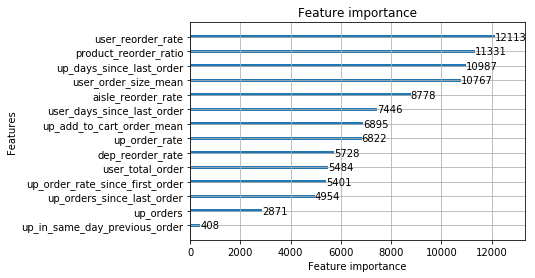

In [30]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()


### Recommendation using threshold

In [31]:
threshold = 0.20
recommend = prediction[prediction.proba >= threshold].groupby('order_id').product_id.apply(list)

In [32]:
prediction.head()

,user_id,product_id,proba,order_id
0,3,39190,0.694264,2774568
1,3,47766,0.684499,2774568
2,3,21903,0.608418,2774568
3,3,43961,0.370602,2774568
4,3,18599,0.354240,2774568


In [33]:
recommend_df = pd.DataFrame()
recommend_df["count"] = prediction.groupby('order_id').size()
recommend_df['product_list'] = recommend
recommend_df['products']= recommend_df.product_list.apply(lambda p: ' '.join([str(x)  for x in p]) if type(p) == list else 'None' ) 

In [34]:
recommend_df.head()

,count,product_list,products
order_id,,,
17,21,"[13107, 21709, 21463, 38777, 47766]",13107 21709 21463 38777 47766
34,78,"[47766, 16083, 39475, 21137, 2596, 43504, 4779...",47766 16083 39475 21137 2596 43504 47792 13176...
137,68,"[24852, 38689, 23794, 41787, 25890, 2326, 5134]",24852 38689 23794 41787 25890 2326 5134
182,100,"[39275, 9337, 5479, 47672, 13629, 41149, 11520...",39275 9337 5479 47672 13629 41149 11520 47209 ...
257,57,"[24852, 49235, 27104, 37646, 27966, 29837, 394...",24852 49235 27104 37646 27966 29837 39475 3023...


In [35]:
recommend_df['products'].to_csv(FEATURES_PATH + 'recommend_totaldata_2.csv', header = True)

### Recommendation using average user basket

In [ ]:
products = []
count = 0
for _,row in test_orders[['user_id', 'order_id']].iterrows():
    count += 1
    if (count)%10000 == 0:
        print(count)    
    
    user_id, order_id = row['user_id'], row['order_id']
    n = int(user_basket_avg.ix[user_id].basket_size_avg)+1
    products.append(list(prediction[prediction.user_id == user_id].product_id[:n]))
    
# create submission
submission = pd.DataFrame()
submission['order_id'] = test_orders['order_id']
submission['products'] = [' '.join([str(x) for x in p]) for p in products]
submission.sort_values(by='order_id', inplace = True)
submission.to_csv(FEATURES_PATH + 'submission.csv', index=False)